In [13]:
from SimPEG import Mesh, Utils, EM
import numpy as np
import matplotlib.pyplot as plt
from pymatsolver import Pardiso
from casingSimulations import view
from matplotlib.colors import LogNorm
import sys
sys.path.append("/Users/sgkang/Projects/casingSimulations/")
from ubc_utils import (
    generate_trapezoidal_waveform, 
    generate_airborne_tdem_data, 
    read_tdoctree_dpred,
    write_tdoctree_dobs,
    read_tdoctree_dobs,
    read_tdoctree_dpred_inversion
)
%matplotlib inline

# Generate a movie: diffusion of currents and fields
This notebook generates movies of diffusing currents and magnetic fields for a conductive sphere in halfspace due to  vertical magnetic dipole (VMD) sources. 
Two VMD sources at different locations (x=0m and 200m) are considered. Both of them are located 30m above from the surface. 

## Step1: Generate 3D cylindrical mesh

In [28]:
csr, csz = 20, 20
ncr, ncz = 30, 40
npadr = 10
npadz = 15
nctheta = 10
cstheta = 2*np.pi/nctheta
hr = Utils.meshTensor([(csr,ncr), (csr,npadr,1.3)])
htheta = Utils.meshTensor([(cstheta, nctheta/2, 1.5), (cstheta,nctheta/2,-1.5)])
htheta /= htheta.sum()
htheta *= 2*np.pi
hz = Utils.meshTensor([(csz,npadz,-1.3), (csz,ncz), (csz,npadz,1.3)])
mesh = Mesh.CylMesh([hr,htheta,hz], x0=[0., 0.,-hz.sum()/2.])
mesh_2d = Mesh.CylMesh([hr, 1 ,hz], x0='00C')

/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/matplotlib/projections/polar.py:67: RuntimeWarning: invalid value encountered in less
  mask = r < 0


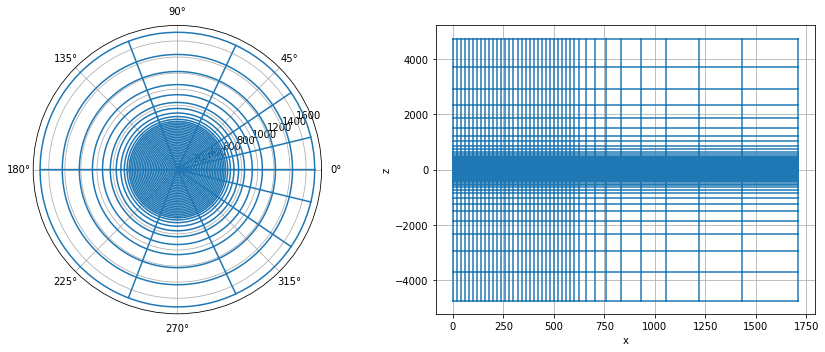

In [29]:
mesh.plotGrid()

## Step2: Generate a conductivity model

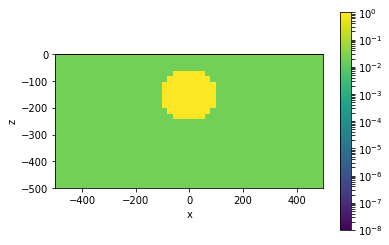

In [32]:
blk_ind = Utils.ModelBuilder.getIndicesSphere(np.r_[0, 0, -150], 100., mesh.gridCC)
actind = mesh.gridCC[:,2]<0.
sigma = np.ones(mesh.nC) * 0.02
sigma[~actind] = 1e-8
sigma[blk_ind] = 1.

view.plot_slice(mesh, sigma, pcolorOpts={'norm':LogNorm()}, theta_ind=7)
plt.xlim(-500, 500)
plt.ylim(-500, 0)
plt.gca().set_aspect(1)

## Step3: Generate TDEM Survey and Problem

In [43]:
rxloc_1 = np.array([[0., 0, 30]], dtype=float)
srcloc_1 = np.array([0., 0, 30], dtype=float)
rxloc_2 = np.array([[200, 0, 30]], dtype=float)
srcloc_2 = np.array([200, 0, 30], dtype=float)

times = np.logspace(-5, -2, 21) + 0.02
rx_1 = EM.TDEM.Rx.Point_dbdt(rxloc_1, times, orientation='z')
rx_2 = EM.TDEM.Rx.Point_dbdt(rxloc_2, times, orientation='z')
time_steps_off_time = [(1e-6, 10), (3e-6, 5), (1e-5, 5), (3e-5, 5), (1e-4, 5), (3e-4, 5), (1e-3, 10)]
time_current, current = generate_trapezoidal_waveform(
    time_steps_off_time=time_steps_off_time,
)
time_current -= time_current[0]
wave = EM.TDEM.Src.TrapezoidWaveform(ramp_on=time_current[:2], ramp_off=time_current[[5,8]])
moment = 13**2*np.pi # assume radius of the loop 13m
src_1 = EM.TDEM.Src.MagDipole([rx_1], loc=srcloc_1, orientation='z', waveform=wave, moment=moment)
src_2 = EM.TDEM.Src.MagDipole([rx_2], loc=srcloc_2, orientation='z', waveform=wave, moment=moment)
survey = EM.TDEM.Survey([src_1, src_2])
prb = EM.TDEM.Problem3D_b(mesh, sigma=sigma, Solver=Pardiso, verbose=True)
prb.timeSteps = np.diff(time_current)
prb.pair(survey)

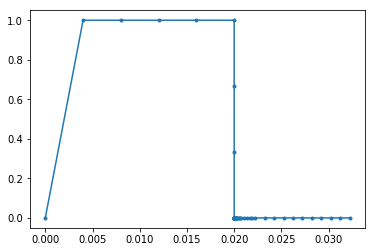

In [44]:
cur = []
for t in prb.times:
    cur.append(wave.eval(t))
cur = np.hstack(cur)
plt.plot(prb.times, cur, '.-')

## Step4: Compue EM fields

In [22]:
f = prb.fields([])

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


Calculating Initial fields
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 3.999400e-03)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
Factoring...   (dt = 1.000000e-06)
Done
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
Factoring...   (dt = 3.000000e-06)
Done


## Step5: Generate a movie

In [23]:
j = f[src_2, 'j']
b = f[src_2, 'b']
core_ind = np.logical_and(mesh_2d.gridEy[:,0]<1000., mesh_2d.gridEy[:,2]<0.) & (mesh_2d.gridEy[:,2]>-500.)
x_ind = mesh_2d.vectorNx<1000.
z_ind = np.logical_and(mesh_2d.vectorNz<100., mesh_2d.vectorNz>-500.)
x = np.r_[-mesh_2d.vectorNx[x_ind][::-1], mesh_2d.vectorNx[x_ind]]
z = mesh_2d.vectorNz[z_ind]
x_ind_cc = mesh_2d.vectorCCx<1000.
z_ind_cc = np.logical_and(mesh_2d.vectorCCz<100., mesh_2d.vectorCCz>-500.)
x_cc = np.r_[-mesh_2d.vectorCCx[x_ind_cc][::-1], mesh_2d.vectorCCx[x_ind_cc]]
z_cc = mesh_2d.vectorCCz[z_ind_cc]

/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/matplotlib/quiver.py:648: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/matplotlib/quiver.py:719: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/matplotlib/quiver.py:733: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minle

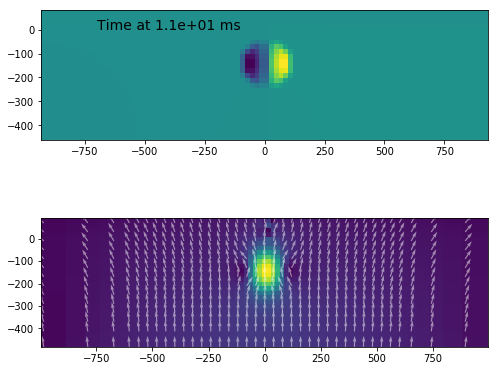

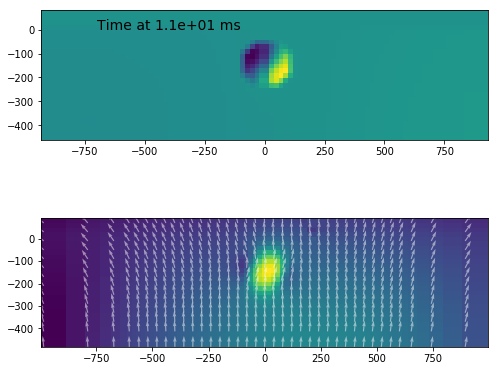

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
nskip = 2
video_names = ['current_sphere_center.mp4', 'current_sphere_side.mp4']
for i, src in enumerate([src_1, src_2]):
    j = f[src, 'j']
    b = f[src, 'b']
    fig = plt.figure(figsize=(8, 7))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    time_text = ax1.text(-700, 0, '', fontsize=14)

    def init():
        value, value_x, value_z, value_abs = foo(0)
        im = ax1.pcolormesh(x, z, value)
        im2 = ax2.pcolormesh(x_cc, z_cc, value_abs)
        im2_1 = ax.quiver(x_cc[::nskip], z_cc[::nskip], (value_x/value_abs)[::nskip,::nskip], (value_z/value_abs)[::nskip,::nskip], color='w', alpha=0.5)        
        time_text.set_text('')
        return im, im2, im2_1, time_text

    def foo(i_time):
        jy = mesh.r(j[:,i_time], xType='E', outType='Ey', format='M')
        jy_2d_r = jy[:,0,:][x_ind,:][:,z_ind]
        jy_2d_l = jy[:,5,:][x_ind,:][:,z_ind]
        jy_2d = np.vstack((-jy_2d_l[::-1,:], jy_2d_r))
        jy_out = (jy_2d.reshape((x.size, z.size), order='F'))

        bx = mesh.r(b[:,i_time], xType='F', outType='Fx')
        bz = mesh.r(b[:,i_time], xType='F', outType='Fz')    
        bx_cc = mesh.r(mesh.aveFx2CC*bx, format="M")
        bz_cc = mesh.r(mesh.aveFz2CC*bz, format="M")
        bx_cc_2d_r = bx_cc[:,0,:][x_ind_cc,:][:,z_ind_cc]
        bx_cc_2d_l = bx_cc[:,5,:][x_ind_cc,:][:,z_ind_cc]
        bz_cc_2d_r = bz_cc[:,0,:][x_ind_cc,:][:,z_ind_cc]
        bz_cc_2d_l = bz_cc[:,5,:][x_ind_cc,:][:,z_ind_cc]    
        bx_cc_2d = np.vstack((-bx_cc_2d_l[::-1,:], bx_cc_2d_r))
        bz_cc_2d = np.vstack((bz_cc_2d_l[::-1,:], bz_cc_2d_r))
        bx_out = bx_cc_2d.reshape((x_cc.size, z_cc.size), order='F')    
        bz_out = bz_cc_2d.reshape((x_cc.size, z_cc.size), order='F') 
        b_abs = np.sqrt(bx_out**2+ bz_out**2)
        return jy_out.T, bx_out.T, bz_out.T, b_abs.T

    def animate(i):    
        value, value_x, value_z, value_abs = foo(i)
        im = ax1.pcolormesh(x, z, value)
        im2 = ax2.pcolormesh(x_cc, z_cc, value_abs)
        im2_1 = ax2.quiver(x_cc[::nskip]+10, z_cc[::nskip], (value_x/value_abs)[::nskip,::nskip], (value_z/value_abs)[::nskip,::nskip], color='w', alpha=0.5)        
        time_text.set_text(("Time at %.1e ms")%((prb.times[i]-0.02)*1e3)) 
        ax1.set_aspect(1)
        ax2.set_aspect(1)
        return im, im2, im2_1, time_text

    ani = animation.FuncAnimation(fig, animate, 53, interval=200, blit=True,
                                    repeat_delay=1000)

    ani.save(video_names[i], dpi=200)